<a href="https://colab.research.google.com/github/NAHIN-JZS/image_colorization/blob/main/resnet50_image_colorization_on_RGB_for_larger_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
from numpy import zeros
from numpy import ones
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model

from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.applications import ResNet50

In [2]:
def define_discriminator(input_image_shape,output_image_shape):
    
	# weight initialization
	init = RandomNormal(stddev=0.02) #As described in the original paper
    
	# source image input
	in_src_image = Input(shape=input_image_shape)  #Image we want to convert to another image
	# target image input
	in_target_image = Input(shape=output_image_shape)  #Image we want to generate after training. 
    
	# concatenate images, channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
    
	# C64: 4x4 kernel Stride 2x2
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128: 4x4 kernel Stride 2x2
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256: 4x4 kernel Stride 2x2
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer : 4x4 kernel but Stride 1x1
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
    
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

In [3]:
'''from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_resnet50_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained ResNet50 Model """
    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = resnet50.get_layer("input_1").output           ## (512 x 512)
    s2 = resnet50.get_layer("conv1_relu").output        ## (256 x 256)
    s3 = resnet50.get_layer("conv2_block3_out").output  ## (128 x 128)
    s4 = resnet50.get_layer("conv3_block4_out").output  ## (64 x 64)

    """ Bridge """
    b1 = resnet50.get_layer("conv4_block6_out").output  ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="ResNet50_U-Net")
    return model

if __name__ == "__main__":
    input_shape = (512, 512, 3)
    model = build_resnet50_unet(input_shape)
    model.summary()'''

'from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input\nfrom tensorflow.keras.models import Model\nfrom tensorflow.keras.applications import ResNet50\n\ndef conv_block(input, num_filters):\n    x = Conv2D(num_filters, 3, padding="same")(input)\n    x = BatchNormalization()(x)\n    x = Activation("relu")(x)\n\n    x = Conv2D(num_filters, 3, padding="same")(x)\n    x = BatchNormalization()(x)\n    x = Activation("relu")(x)\n\n    return x\n\ndef decoder_block(input, skip_features, num_filters):\n    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)\n    x = Concatenate()([x, skip_features])\n    x = conv_block(x, num_filters)\n    return x\n\ndef build_resnet50_unet(input_shape):\n    """ Input """\n    inputs = Input(input_shape)\n\n    """ Pre-trained ResNet50 Model """\n    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)\n\n    """ Encoder """\n    s1 = resnet5

In [4]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [5]:
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate(axis = -1)([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [6]:
def define_generator(input_image_shape=(512,512,3),output_image_shape=(512,512,3)):
  """ Input """
  inputs = Input(input_image_shape)

  """ Pre-trained ResNet50 Model """
  # resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)
  pre_model = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)
  # pre_model = tf.keras.applications.MobileNetV2(input_shape = input_image_shape, include_top=False, weights="imagenet")

  """ Encoder """
  # s1 = resnet50.get_layer("input_39").output           ## (512 x 512)
  s2 = pre_model.get_layer("conv1_relu").output        ## (256 x 256)
  s3 = pre_model.get_layer("conv2_block3_out").output  ## (128 x 128)
  s4 = pre_model.get_layer("conv3_block4_out").output  ## (64 x 64)

  '''layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]'''

  # s1 = mobileNet.get_layer('block_1_expand_relu').output
  # s2 = mobileNet.get_layer('block_3_expand_relu').output
  # s3 = mobileNet.get_layer('block_6_expand_relu').output
  # s4 = mobileNet.get_layer('block_13_expand_relu').output
  # s5 = mobileNet.get_layer('block_16_expand_relu').output

  """ Bridge """
  b1 = pre_model.get_layer("conv4_block6_out").output  ## (32 x 32)
  # b1 = mobileNet.get_layer('block_16_expand_relu').output

  """ Decoder """
  d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
  d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
  d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
  # d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)
  # d4 = Conv2DTranspose(64, (2, 2), strides=2, padding="same")(d3)
  # d4 = Concatenate(axis = -1)([x, skip_features])
  # d4 = conv_block(d4, 64)

  """ Output """
  # g = Conv2DTranspose(output_image_shape[2], (4,4), strides=(2,2), padding='same')(d4) #Modified
  g = Conv2DTranspose(output_image_shape[2], (4,4), strides=(2,2), padding='same')(d3) 
  outputs = Activation('tanh')(g)  #Generates images in the range -1 to 1. So change inputs also to -1 to 1

  model = Model(inputs, outputs, name="ResNet50_U-Net")
  return model

In [7]:
'''# define the standalone generator model - U-net
def define_generator(input_image_shape=(256,256,1),output_image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=input_image_shape)
	# encoder model: C64-C128-C256-C512-C512-C512-C512-C512
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model: CD512-CD512-CD512-C512-C256-C128-C64
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(output_image_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7) #Modified 
	out_image = Activation('tanh')(g)  #Generates images in the range -1 to 1. So change inputs also to -1 to 1
	# define model
	model = Model(in_image, out_image)
	return model
'''

"# define the standalone generator model - U-net\ndef define_generator(input_image_shape=(256,256,1),output_image_shape=(256,256,3)):\n\t# weight initialization\n\tinit = RandomNormal(stddev=0.02)\n\t# image input\n\tin_image = Input(shape=input_image_shape)\n\t# encoder model: C64-C128-C256-C512-C512-C512-C512-C512\n\te1 = define_encoder_block(in_image, 64, batchnorm=False)\n\te2 = define_encoder_block(e1, 128)\n\te3 = define_encoder_block(e2, 256)\n\te4 = define_encoder_block(e3, 512)\n\te5 = define_encoder_block(e4, 512)\n\te6 = define_encoder_block(e5, 512)\n\te7 = define_encoder_block(e6, 512)\n\t# bottleneck, no batch norm and relu\n\tb = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)\n\tb = Activation('relu')(b)\n\t# decoder model: CD512-CD512-CD512-C512-C256-C128-C64\n\td1 = decoder_block(b, e7, 512)\n\td2 = decoder_block(d1, e6, 512)\n\td3 = decoder_block(d2, e5, 512)\n\td4 = decoder_block(d3, e4, 512, dropout=False)\n\td5 = decoder_block(d4, e3

In [8]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, input_image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
            
	# define the source image
	in_src = Input(shape=input_image_shape)
	# suppy the image as input to the generator 
	gen_out = g_model(in_src)
	# supply the input image and generated image as inputs to the discriminator
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and disc. output as outputs
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
    
	model.compile(loss=['binary_crossentropy', 'mae'], 
               optimizer=opt, loss_weights=[1,100])
	return model

In [9]:

def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

In [10]:


# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [11]:

# def summarize_performance(step, g_model, dataset,weight_folder, n_samples=3):
# 	# select a sample of input images
# 	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
# 	# generate a batch of fake samples
# 	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
# 	# scale all pixels from [-1,1] to [0,1]
# 	X_realA = (X_realA + 1) / 2.0
# 	X_realB = (X_realB + 1) / 2.0
# 	X_fakeB = (X_fakeB + 1) / 2.0
# 	# plot real source images
# 	for i in range(n_samples):
# 		plt.subplot(3, n_samples, 1 + i)
# 		plt.axis('off')
# 		re = np.squeeze(X_realA[i])
# 		plt.imshow(re,'gray')
# 	# plot generated target image
# 	for i in range(n_samples):
# 		plt.subplot(3, n_samples, 1 + n_samples + i)
# 		plt.axis('off')
# 		plt.imshow(X_fakeB[i])
# 	# plot real target image
# 	for i in range(n_samples):
# 		plt.subplot(3, n_samples, 1 + n_samples*2 + i)
# 		plt.axis('off')
# 		plt.imshow(X_realB[i])
# 	# save plot to file
# 	#filename1 = '/content/gdrive/MyDrive/Thesis/Dataset/test/few_image/chkpoint/plot_%06d.png' % (step+1)
# 	#plt.savefig(filename1)
# 	#plt.close()
# 	# save the generator model
# 	filename2 = weight_folder +'/model_%06d.h5' % (step+1)
# 	g_model.save(filename2)
# 	print('>Saved: %s' % ( filename2))


In [12]:
def summarize_performance(step, g_model, d_model, gan_model, weight_folder):
	# select a sample of input images
	
	# save the generator model
	g_model_filename = weight_folder + '/g_model_%06d.h5' % (step+1)
	g_model.save(g_model_filename)
	print('>Saved: %s' % ( g_model_filename))

	# save the discriminator model
	d_model_filename = weight_folder + '/d_model_%06d.h5' % (step+1)
	d_model.save(d_model_filename)
	print('>Saved: %s' % (d_model_filename))

	# save the gan model
	gan_model_filename = weight_folder + '/gan_model_%06d.h5' % (step+1)
	gan_model.save(gan_model_filename)
	print('>Saved: %s' % ( gan_model_filename))

In [13]:
import tensorflow as tf
from os import listdir
from numpy import asarray, load
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
from matplotlib import pyplot
import numpy as np
from PIL import Image, ImageOps

In [14]:
# This function will create a list of image path
def generate_image_path_list(folder_name):
  path_list = list() 
  for filename in listdir(folder_name):
    path_list.append(filename)
  return path_list

In [15]:
# load all images in a directory into memory
def load_images(im_indecator, im_path_list, im_path, batch_size, size=(256,256)):
	src_list, tar_list = list(), list()
	# enumerate filenames in directory, assume all are images
	# for filename in listdir(path):
	if ((im_indecator + batch_size) > len(im_path_list)):
		batch_size = len(im_path_list) - im_indecator
	for j in range(batch_size):

		# load and resize the image
		#pixels = load_img(path + filename, target_size=size)
		rgb_image = load_img(path + im_path_list[im_indecator+j], target_size=size)
		gray_image = ImageOps.grayscale(rgb_image)
		
		# gray_image = tf.image.rgb_to_grayscale(rgb_image)
		# convert to numpy array
		rgb_pixels = img_to_array(rgb_image)
		gray_pixels = img_to_array(gray_image)

		#To make the source image into 3 channels so that it can be feed into the resnet50 model
		gray_image_3band = np.repeat(gray_pixels, repeats = 3, axis = -1)

		# split into satellite and map
		#sat_img, map_img = pixels[:, :256], pixels[:, 256:]
		# src_list.append(gray_pixels)
		src_list.append(gray_image_3band)
		tar_list.append(rgb_pixels)
	return [asarray(src_list), asarray(tar_list)]

In [16]:

def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]



In [17]:


# train pix2pix models
# def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):

def train(d_model, g_model, gan_model, im_path_list, im_path, weight_folder, save_weight_file_after = 10, n_epochs=100, n_batch=1):
	"""This function is used to train the GAN

	Args:
		d_model (keras model): discriminator model
		g_model (keras model): generator model
		gan_model (keras model): combine of d_model and g_model or GAN
		im_path_list (list): this will contain all image name in the dataset(main image) folder
		im_path (string): dataset path or image path 
		weight_folder (string): folder to save weight file
		save_weight_file_after (int, optional): number of epoch to save weight file. mane koita wpoch er por weight file save korbe. Defaults to 10.
		n_epochs (int, optional): Total number of epoch. Defaults to 100.
		n_batch (int, optional): number of batch. Defaults to 1.
	"""


	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	# trainA, trainB = dataset
	# calculate the number of batches per training epoch
	# bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	# n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	total_image = len(im_path_list)
	for i in range(n_epochs):
		im_indicator = 0 # Track of current image
		while (im_indicator < total_image):
				[src_images, tar_images]  = load_images(im_indicator, im_path_list = im_path_list, im_path = im_path, batch_size = n_batch)
				dataset = preprocess_data([src_images, tar_images])
				trainA, trainB = dataset

				im_indicator = im_indicator + n_batch


				# select a batch of real samples
				[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
				# generate a batch of fake samples
				X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
				# update discriminator for real samples
				d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
				# update discriminator for generated samples
				d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
				# update the generator
				g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
				# summarize performance
				print('>epoch: %d, batch: %d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1,im_indicator/n_batch, d_loss1, d_loss2, g_loss))
				# summarize model performance
		if (i+1) %  save_weight_file_after == 0:

			[src_images, tar_images]  = load_images(im_indicator- n_batch , im_path_list = im_path_list, im_path = im_path, batch_size = n_batch)
			dataset = preprocess_data([src_images, tar_images])
			summarize_performance(i, g_model = g_model, d_model = d_model, gan_model = gan_model, weight_folder = weight_folder)

In [18]:
# """Checking the load_images function...ignore"""




# path = '/content/gdrive/MyDrive/3200_Project/Project/Zahim_folder/New_Image/'
# path_list = generate_image_path_list(path)
# # load dataset
# [src_images, tar_images] = load_images(im_indecator = 0, im_path_list = path_list, im_path = path, batch_size = 1, size=(256,256))
# print('Loaded: ', src_images.shape, tar_images.shape)


# n_samples = 1
# for i in range(n_samples):
# 	pyplot.subplot(2, n_samples, 1 + i)
# 	pyplot.axis('off')
# 	re = np.squeeze(src_images[i])
# 	pyplot.imshow(re.astype('uint8'),'gray')
# # plot target image
# for i in range(n_samples):
# 	pyplot.subplot(2, n_samples, 1 + n_samples + i)
# 	pyplot.axis('off')
# 	pyplot.imshow(tar_images[i].astype('uint8'))
# pyplot.show()

#######################################



In [19]:
#from pix2pix_model import define_discriminator, define_generator, define_gan, train
# define input shape based on the loaded dataset
# input_image_shape = src_images.shape[1:]
# output_image_shape = tar_images.shape[1:]
input_image_shape = (256,256,3)
output_image_shape = (256,256,3)
# define the models
d_model = define_discriminator(input_image_shape,output_image_shape)
g_model = define_generator(input_image_shape,output_image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, input_image_shape)

#Define data
# load and prepare training images
# data = [src_images, tar_images]

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


94781440/94765736 [==============================] - 1s 0us/step


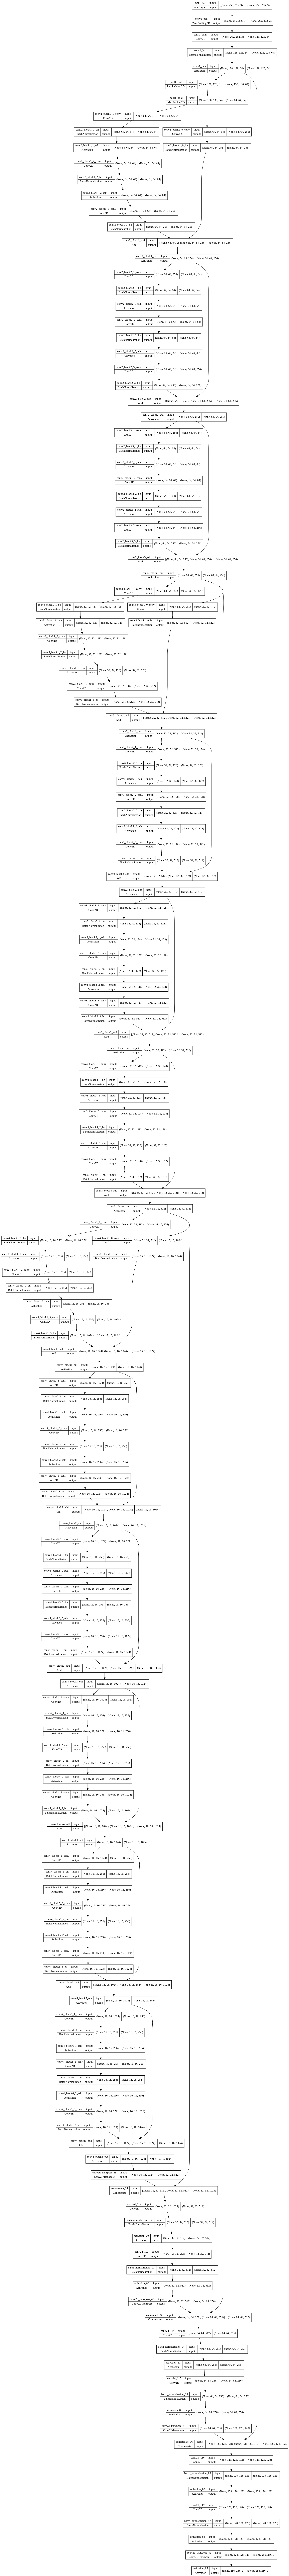

In [ ]:
tf.keras.utils.plot_model(g_model, "multi_input_and_output_model.png", show_shapes=True)

In [ ]:
g_model.summary()

Model: "ResNet50_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_27[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                     

In [ ]:
# dataset = preprocess_data(data)

In [ ]:
path = '/content/gdrive/MyDrive/3200_Project/Project/Zahim_folder/New_Image/'
weight_folder = '/content/gdrive/MyDrive/Thesis/Dataset/test/chkpoint1'
path_list = generate_image_path_list(path)

In [ ]:
from skimage.transform import resize
rgb_image = load_img('/content/gdrive/MyDrive/3200_Project/Project/Zahim_folder/New_Image/153502366_121511479897472_4238414869225157225_n.jpg' , target_size=(256,256,3))
gray_image = ImageOps.grayscale(rgb_image)
gray_image = img_to_array(gray_image)
gre = np.squeeze(gray_image)
# re = resize(gray_image, (256, 256, 3), mode='constant')

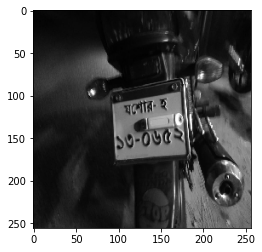

In [ ]:
pyplot.imshow(gray_image_3band[:,:,2],'gray')

In [ ]:
import numpy as np
gray_image_3band = np.repeat(gray_image, repeats = 3, axis = -1)
gray_image_3band.shape

(256, 256, 3)

In [ ]:
# gray_image_3band

In [ ]:
# ar = np.array([[3,3,3],[4,4,4]])
# print(ar.shape)
# arr = np.repeat(ar[..., np.newaxis], repeats = 3, axis = -1)
# print(arr.shape)
# arr

(2, 3)
(2, 3, 3)


array([[[3, 3, 3],
        [3, 3, 3],
        [3, 3, 3]],

       [[4, 4, 4],
        [4, 4, 4],
        [4, 4, 4]]])

>epoch: 1, batch: 1, d1[0.523] d2[0.588] g[57.686]
>epoch: 1, batch: 2, d1[0.419] d2[0.977] g[53.771]
>epoch: 1, batch: 3, d1[0.658] d2[0.498] g[45.949]
>epoch: 1, batch: 4, d1[0.492] d2[0.503] g[37.788]
>epoch: 1, batch: 5, d1[0.461] d2[0.441] g[34.103]
>epoch: 1, batch: 6, d1[0.430] d2[0.404] g[28.228]
>epoch: 1, batch: 7, d1[0.403] d2[0.353] g[39.630]
>epoch: 1, batch: 8, d1[0.475] d2[0.340] g[37.345]
>epoch: 1, batch: 9, d1[0.367] d2[0.317] g[32.230]
>epoch: 2, batch: 1, d1[0.330] d2[0.307] g[25.302]
>epoch: 2, batch: 2, d1[0.363] d2[0.308] g[27.929]
>epoch: 2, batch: 3, d1[0.311] d2[0.265] g[27.679]
>epoch: 2, batch: 4, d1[0.260] d2[0.244] g[24.651]
>epoch: 2, batch: 5, d1[0.391] d2[0.384] g[21.866]
>epoch: 2, batch: 6, d1[0.324] d2[0.540] g[21.850]
>epoch: 2, batch: 7, d1[0.291] d2[0.407] g[24.354]
>epoch: 2, batch: 8, d1[0.247] d2[0.259] g[33.786]
>epoch: 2, batch: 9, d1[0.228] d2[0.239] g[24.926]
>epoch: 3, batch: 1, d1[0.246] d2[0.227] g[27.892]
>epoch: 3, batch: 2, d1[0.228] 

>Saved: /content/gdrive/MyDrive/Thesis/Dataset/test/chkpoint1/model_000010.h5
>epoch: 11, batch: 1, d1[0.012] d2[0.030] g[19.034]
>epoch: 11, batch: 2, d1[0.020] d2[0.125] g[14.790]
>epoch: 11, batch: 3, d1[0.011] d2[0.125] g[15.203]
>epoch: 11, batch: 4, d1[0.028] d2[0.174] g[14.845]
>epoch: 11, batch: 5, d1[0.202] d2[0.045] g[21.232]
>epoch: 11, batch: 6, d1[0.261] d2[0.099] g[18.288]
>epoch: 11, batch: 7, d1[0.026] d2[0.140] g[10.923]
>epoch: 11, batch: 8, d1[0.081] d2[0.010] g[12.655]
>epoch: 11, batch: 9, d1[0.069] d2[0.009] g[8.946]
>epoch: 12, batch: 1, d1[0.032] d2[0.009] g[17.447]
>epoch: 12, batch: 2, d1[0.076] d2[0.011] g[17.279]
>epoch: 12, batch: 3, d1[0.051] d2[0.012] g[16.385]
>epoch: 12, batch: 4, d1[0.033] d2[0.012] g[19.722]
>epoch: 12, batch: 5, d1[0.026] d2[0.016] g[19.007]
>epoch: 12, batch: 6, d1[0.023] d2[0.014] g[14.122]
>epoch: 12, batch: 7, d1[0.015] d2[0.009] g[13.522]


KeyboardInterrupt: ignored

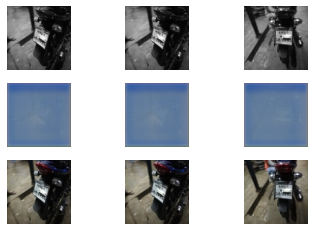

In [ ]:
from datetime import datetime 
start1 = datetime.now() 

# train(d_model, g_model, gan_model, dataset, n_epochs=150, n_batch=1) 
train(d_model, g_model, gan_model, im_path_list = path_list, im_path = path, weight_folder = weight_folder, n_epochs=100, n_batch=7)
stop1 = datetime.now()
#Execution time of the model 
execution_time = stop1-start1
print("Execution time is: ", execution_time)


In [ ]:
#Test trained model on image...

from keras.models import load_model
from numpy.random import randint
# model = load_model('/content/gdrive/MyDrive/Thesis/Dataset/test/chkpoint1/model_000002.h5')
model = load_model('/content/gdrive/MyDrive/Thesis/Dataset/test/chkpoint1/model_000010.h5')

In [ ]:
#function to load a single image for test
def load_single_images(path, size=(256,256)):
    src_list, tar_list = list(), list()
    rgb_image = load_img(path, target_size=size)
    gray_image = ImageOps.grayscale(rgb_image)
    # gray_image = tf.image.rgb_to_grayscale(rgb_image)
    # convert to numpy array
    rgb_pixels = img_to_array(rgb_image)
    gray_pixels = img_to_array(gray_image)
    gray_image_3band = np.repeat(gray_pixels, repeats = 3, axis = -1)
    # split into satellite and map
    #sat_img, map_img = pixels[:, :256], pixels[:, 256:]
    src_list.append(gray_image_3band)
    tar_list.append(rgb_pixels)
    return [asarray(src_list), asarray(tar_list)]

In [ ]:
test_data = load_single_images('/content/gdrive/MyDrive/Thesis/Dataset/test/few_image/20056.jpg')


(2, 256, 256, 3)


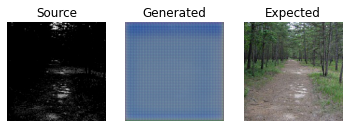

In [ ]:
# plot source, generated and target images
def plot_images(src_img, gen_img, tar_img):
  
  images = vstack(( gen_img, tar_img))
  #images = src_img
  # scale from [-1,1] to [0,1]
  images = (images + 1) / 2.0
  titles = ['Source', 'Generated', 'Expected']
  pyplot.subplot(1,3,1)
  pyplot.axis('off')
  re = np.squeeze(src_image)
  pyplot.imshow(re,'gray')
  pyplot.title(titles[0])
  # plot images row by row
  for i in range(len(images)):
    
    # define subplot
    pyplot.subplot(1, 3, 2 + i)# turn off axis
    pyplot.axis('off')# plot raw pixel data
    pyplot.imshow(images[i])# show title
    pyplot.title(titles[i+1])
  print(images.shape)
  # pyplot.subplot(1,3,1)
  # pyplot.imshow(images[0,:,:,:])
  pyplot.show()



#[X1, X2] = dataset
# select random example
#ix = randint(0, len(X1), 1)
#src_image, tar_image = X1[ix], X2[ix]
# src_image, tar_image = test_data
src_image, tar_image = preprocess_data(test_data)
# generate image from source
gen_image = model.predict(src_image)
# plot all three images
plot_images(src_image, gen_image, tar_image)

In [ ]:
gen_image.shape

(1, 256, 256, 3)

In [ ]:
re = np.squeeze(src_image)
re.shape

(256, 256)

In [ ]:
src_image.shape

(1, 256, 256, 1)